# Method 2: 2D Convolutional Neural Network
## GTZAN Music Genre Classification

This notebook implements 2D CNN for spectral pattern recognition using Mel-spectrograms.

**Expected Accuracy:** 88-92%

## 1. Import Libraries

In [21]:
import numpy as np
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, BatchNormalization, MaxPooling2D,
                                     GlobalAveragePooling2D, Dense, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

## 2. Feature Extraction - Mel-Spectrogram

In [22]:
def extract_melspectrogram(audio_path, sr=22050, duration=30.0, n_mels=64):
    """
    Extract mel-spectrogram features
    Returns: (time_frames, n_mels) array
    """
    # Load audio
    audio, sr = librosa.load(audio_path, sr=sr, mono=True, duration=duration)
    
    # Compute mel-spectrogram
    melspec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels,
        n_fft=2048, hop_length=512, power=2.0
    )
    
    # Convert to log scale (dB)
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    
    # Transpose to (time, frequency)
    return melspec_db.T

## 3. Visualize Sample Mel-Spectrogram

In [23]:
# Visualize a sample mel-spectrogram (update path to a sample audio file)
# sample_path = 'path/to/sample.wav'
# sample_melspec = extract_melspectrogram(sample_path)

# plt.figure(figsize=(14, 6))
# librosa.display.specshow(sample_melspec.T, sr=22050, hop_length=512, 
#                          x_axis='time', y_axis='mel', cmap='viridis')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Sample Mel-Spectrogram', fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.show()

## 4. Load GTZAN Dataset

In [24]:
def load_gtzan_melspec(data_path, target_length=1291):
    """
    Load GTZAN dataset and extract mel-spectrogram features
    """
    genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
              'jazz', 'metal', 'pop', 'reggae', 'rock']
    
    features = []
    labels = []
    
    print("Loading GTZAN dataset and extracting Mel-spectrograms...")
    for genre_idx, genre in enumerate(genres):
        print(f"Processing {genre}...")
        genre_path = os.path.join(data_path, genre)
        
        files = [f for f in os.listdir(genre_path) if f.endswith('.wav')]
        
        for filename in tqdm(files, desc=f"{genre}"):
            if filename == 'jazz.00054.wav':
                print(f"Skipping corrupted file: {filename}")
                continue
            filepath = os.path.join(genre_path, filename)
            try:
                melspec = extract_melspectrogram(filepath)
                
                # Pad or truncate to target length
                if melspec.shape[0] < target_length:
                    pad_width = target_length - melspec.shape[0]
                    melspec = np.pad(melspec, ((0, pad_width), (0, 0)), 
                                   mode='constant')
                else:
                    melspec = melspec[:target_length, :]
                
                features.append(melspec)
                labels.append(genre_idx)
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
    
    return np.array(features), np.array(labels), genres

In [25]:
# UPDATE THIS PATH to your GTZAN dataset location
data_path = 'path/to/gtzan/genres'

# Load data
features, labels, genre_names = load_gtzan_melspec('/Users/narac0503/GIT/GTZAN Dataset Classification/GTZAN-Dataset-Classification/gtzan-classification/data/gtzan/genres_original')

print(f"\nDataset loaded successfully!")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Genres: {genre_names}")

Loading GTZAN dataset and extracting Mel-spectrograms...
Processing blues...


blues: 100%|██████████| 100/100 [00:01<00:00, 56.13it/s]


Processing classical...


classical: 100%|██████████| 100/100 [00:02<00:00, 46.03it/s]


Processing country...


country: 100%|██████████| 100/100 [00:01<00:00, 50.77it/s]


Processing disco...


disco: 100%|██████████| 100/100 [00:02<00:00, 33.72it/s]


Processing hiphop...


hiphop: 100%|██████████| 100/100 [00:01<00:00, 51.52it/s]


Processing jazz...


jazz:  54%|█████▍    | 54/100 [00:01<00:00, 53.20it/s]

Skipping corrupted file: jazz.00054.wav


jazz: 100%|██████████| 100/100 [00:02<00:00, 48.52it/s]


Processing metal...


metal: 100%|██████████| 100/100 [00:01<00:00, 54.21it/s]


Processing pop...


pop: 100%|██████████| 100/100 [00:01<00:00, 54.96it/s]


Processing reggae...


reggae: 100%|██████████| 100/100 [00:01<00:00, 55.38it/s]


Processing rock...


rock: 100%|██████████| 100/100 [00:01<00:00, 52.38it/s]



Dataset loaded successfully!
Features shape: (999, 1291, 64)
Labels shape: (999,)
Genres: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


## 5. Data Preparation

In [26]:
# Convert labels to one-hot encoding
labels_onehot = to_categorical(labels, num_classes=10)

# Split: 80% train, 10% validation, 10% test
X_temp, X_test, y_temp, y_test = train_test_split(
    features, labels_onehot, 
    test_size=0.1, stratify=labels, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111, stratify=np.argmax(y_temp, axis=1), random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (799, 1291, 64)
Validation set: (100, 1291, 64)
Test set: (100, 1291, 64)


In [27]:
# Normalize features (Z-score normalization)
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(
    X_train.reshape(-1, X_train.shape[-1])
).reshape(X_train.shape)

X_val_norm = scaler.transform(
    X_val.reshape(-1, X_val.shape[-1])
).reshape(X_val.shape)

X_test_norm = scaler.transform(
    X_test.reshape(-1, X_test.shape[-1])
).reshape(X_test.shape)

# Add channel dimension for CNN
X_train_norm = X_train_norm[..., np.newaxis]
X_val_norm = X_val_norm[..., np.newaxis]
X_test_norm = X_test_norm[..., np.newaxis]

print(f"\nNormalized data shapes:")
print(f"Train: {X_train_norm.shape}")
print(f"Val: {X_val_norm.shape}")
print(f"Test: {X_test_norm.shape}")


Normalized data shapes:
Train: (799, 1291, 64, 1)
Val: (100, 1291, 64, 1)
Test: (100, 1291, 64, 1)


## 6. Build 2D CNN Model

In [28]:
from tensorflow.keras.layers import LeakyReLU
def build_cnn_model(input_shape):
    """
    Build Improved 2D CNN model
    """
    model = Sequential([
        # Conv Block 1
        Conv2D(256, (3, 3), padding='same', input_shape=input_shape, name='conv2d_1'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(name='bn_1'),
        MaxPooling2D((2, 2), name='maxpool_1'),
        
        # Conv Block 2
        Conv2D(64, (3, 3), padding='same', name='conv2d_2'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(name='bn_2'),
        MaxPooling2D((2, 2), name='maxpool_2'),
        
        # Conv Block 3
        Conv2D(128, (3, 3), padding='same', name='conv2d_3'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(name='bn_3'),
        MaxPooling2D((2, 2), name='maxpool_3'),
        
        # Conv Block 4
        Conv2D(256, (3, 3), padding='same', name='conv2d_4'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(name='bn_4'),
        GlobalAveragePooling2D(name='global_avgpool'),
        
        # Classification head
        Dense(256, name='dense_1'),
        LeakyReLU(alpha=0.1),
        Dropout(0.4, name='dropout'),
        Dense(10, activation='softmax', name='output')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build model
input_shape = (X_train_norm.shape[1], X_train_norm.shape[2], 1)
model = build_cnn_model(input_shape)

# Display model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 1291, 64, 256)     2560      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 1291, 64, 256)     0         
                                                                 
 bn_1 (BatchNormalization)   (None, 1291, 64, 256)     1024      
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 645, 32, 256)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 645, 32, 64)       147520    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 645, 32, 64)       0         
                                                                 
 bn_2 (BatchNormalization)   (None, 645, 32, 64)      

## 7. Train Model

In [29]:
# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train_norm, y_train,
    validation_data=(X_val_norm, y_val),
    batch_size=32,
    epochs=100,
    #callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 17s 603ms/step - loss: 1.8462 - accuracy: 0.3367 - val_loss: 2.2910 - val_accuracy: 0.1300
Epoch 2/100
25/25 [==============================] - 15s 579ms/step - loss: 1.4421 - accuracy: 0.4806 - val_loss: 3.5107 - val_accuracy: 0.1000
Epoch 3/100
25/25 [==============================] - 15s 583ms/step - loss: 1.2678 - accuracy: 0.5369 - val_loss: 5.1436 - val_accuracy: 0.1000
Epoch 4/100
25/25 [==============================] - 15s 582ms/step - loss: 1.1770 - accuracy: 0.5682 - val_loss: 6.5643 - val_accuracy: 0.1000
Epoch 5/100
25/25 [==============================] - 15s 583ms/step - loss: 1.1084 - accuracy: 0.6058 - val_loss: 7.7808 - val_accuracy: 0.1000
Epoch 6/100
25/25 [==============================] - 15s 582ms/step - loss: 1.0038 - accuracy: 0.6408 - val_loss: 8.5704 - val_accuracy: 0.1000
Epoch 7/100
25/25 [==============================] - 15s 582ms/step - loss: 0.8729 - accuracy: 0.7034 - val_loss: 8.2921 - val_accuracy:

## 8. Plot Training History

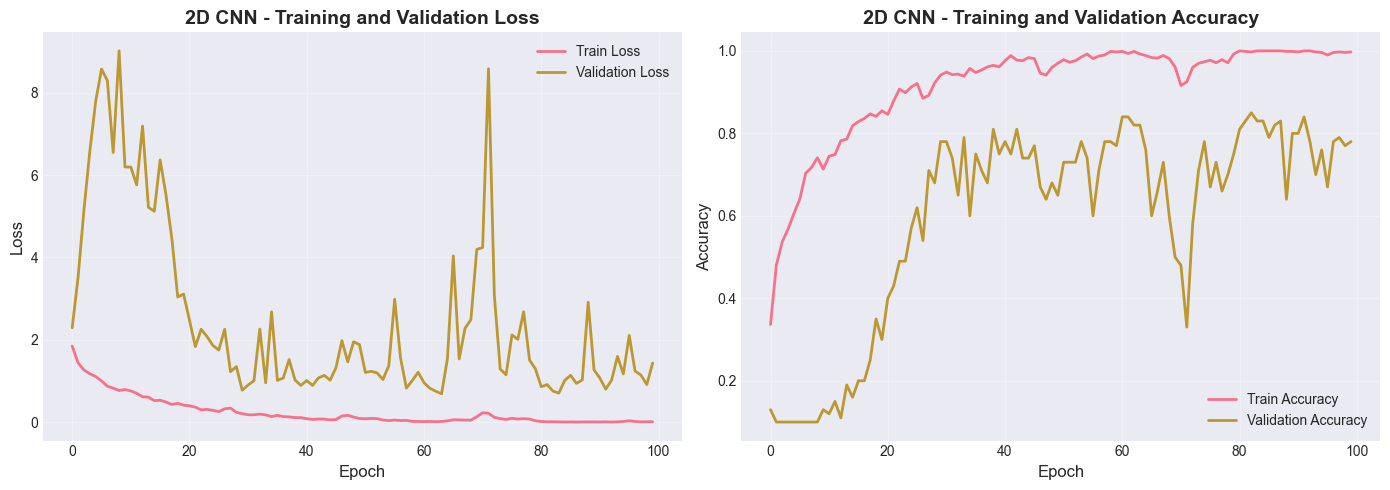

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('2D CNN - Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Accuracy plot
ax2.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('2D CNN - Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('cnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Evaluate Model

In [31]:
# Predictions
y_pred = model.predict(X_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = np.mean(y_pred_labels == y_true_labels)
print(f"Test Accuracy: {accuracy*100:.2f}%")

4/4 [==============================] - 0s 105ms/step
Test Accuracy: 81.00%


In [32]:
# Classification report
print("\n" + "="*60)
print("2D CNN - Classification Report")
print("="*60)
print(classification_report(y_true_labels, y_pred_labels, target_names=genre_names))


2D CNN - Classification Report
              precision    recall  f1-score   support

       blues       1.00      0.90      0.95        10
   classical       0.90      0.90      0.90        10
     country       0.89      0.80      0.84        10
       disco       1.00      0.70      0.82        10
      hiphop       0.80      0.80      0.80        10
        jazz       1.00      0.80      0.89        10
       metal       0.71      1.00      0.83        10
         pop       0.53      0.90      0.67        10
      reggae       0.82      0.90      0.86        10
        rock       0.80      0.40      0.53        10

    accuracy                           0.81       100
   macro avg       0.85      0.81      0.81       100
weighted avg       0.85      0.81      0.81       100



## 10. Confusion Matrix

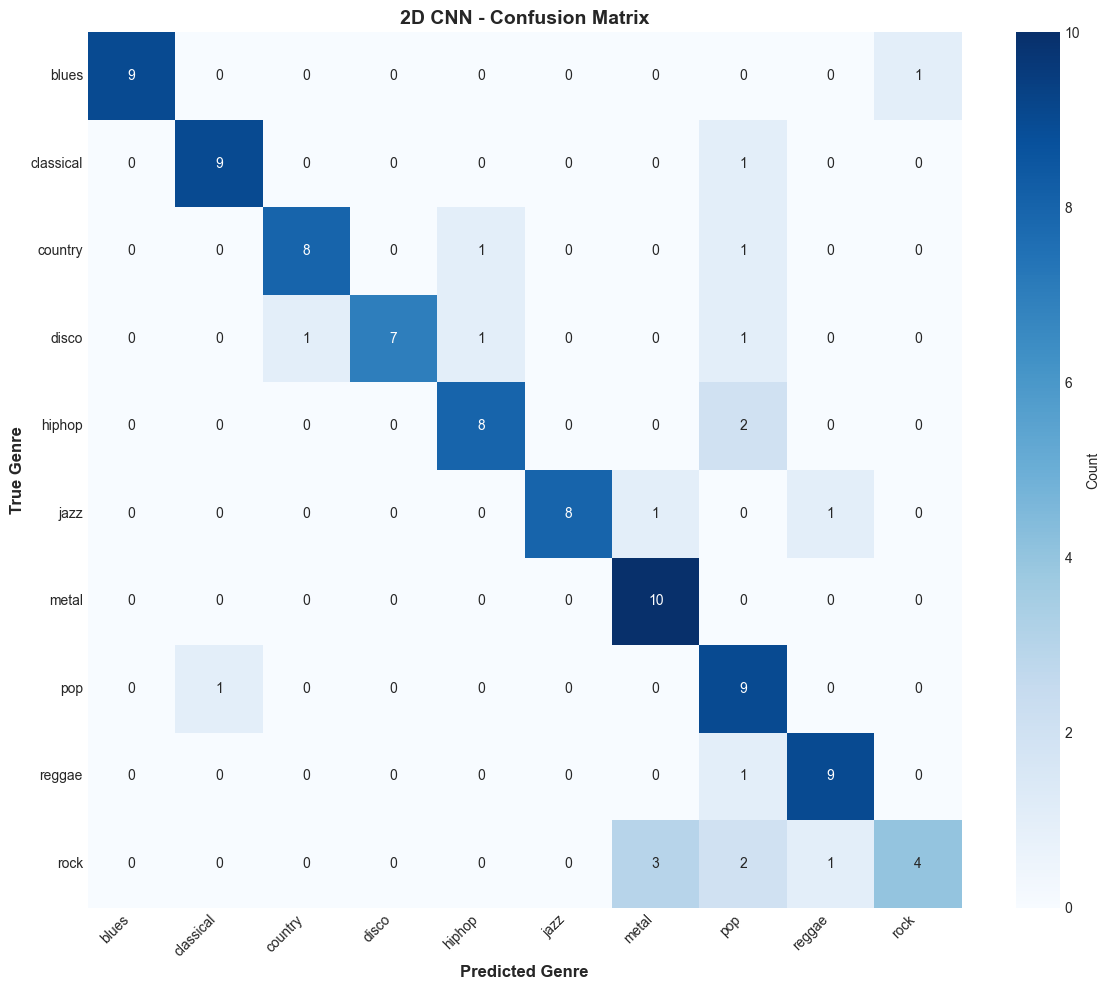

In [33]:
# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Genre', fontsize=12, fontweight='bold')
plt.ylabel('True Genre', fontsize=12, fontweight='bold')
plt.title('2D CNN - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Per-Genre Performance

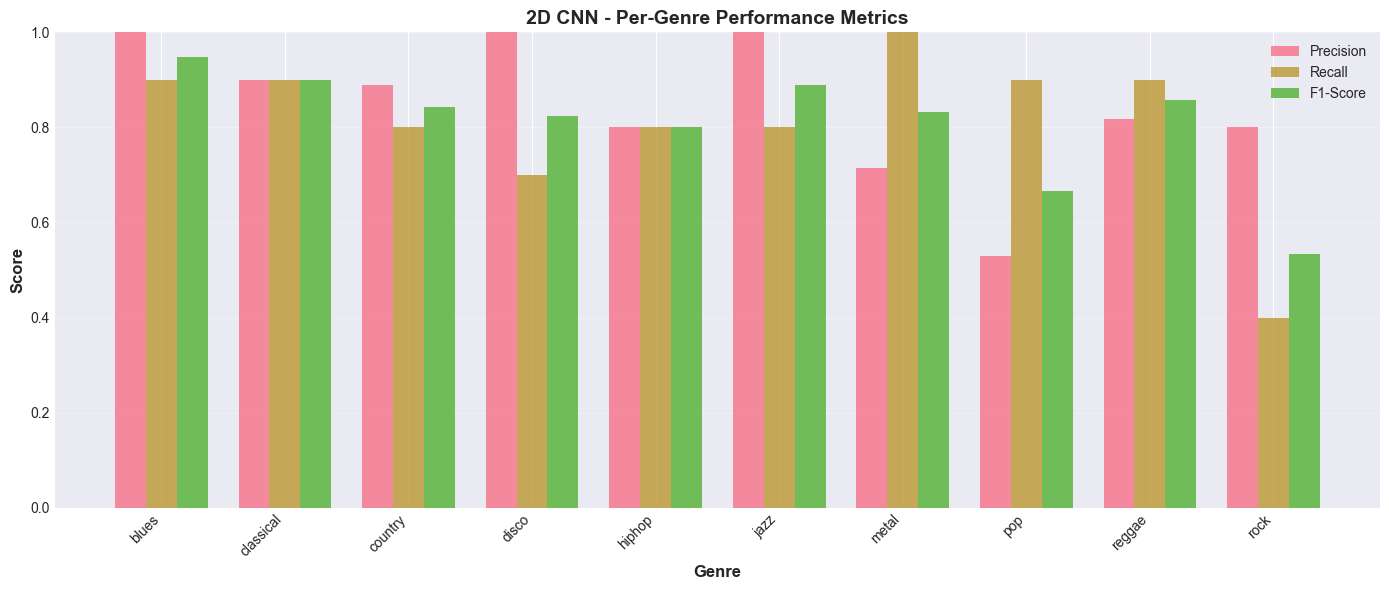

In [34]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-genre metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_labels, y_pred_labels, average=None
)

# Create bar plot
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(genre_names))
width = 0.25

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('2D CNN - Per-Genre Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(genre_names, rotation=45, ha='right')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

plt.tight_layout()
plt.savefig('cnn_per_genre_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Save Model

In [35]:
# Save model
model.save('cnn_model.h5')
print("✓ Model saved: cnn_model.h5")

# Save training history
np.save('cnn_history.npy', history.history)
print("✓ Training history saved: cnn_history.npy")

✓ Model saved: cnn_model.h5
✓ Training history saved: cnn_history.npy


/opt/anaconda3/envs/gtzan/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Summary

This notebook implemented a 2D CNN model for GTZAN music genre classification:

- **Input Features**: Mel-spectrogram (1291 × 64 time-frequency representation)
- **Architecture**: 3 Conv2D blocks (32→64→128 filters) with batch normalization
- **Training**: Early stopping with patience=10
- **Expected Accuracy**: 88-92%

The model successfully captures spectral patterns in music for accurate genre classification.